In [1]:
from __future__ import division, print_function
import numpy as np
import codecs
import re
import json
import random
from collections import defaultdict, Counter
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import lxmls.readers.simple_sequence as ssr
simple = ssr.SimpleSequence()
print(simple.train)
# [walk/rainy walk/sunny shop/sunny clean/sunny , walk/rainy walk/rainy shop/rainy clean/
# sunny , walk/sunny shop/sunny shop/sunny clean/sunny ]
print(simple.test)


[walk/rainy walk/sunny shop/sunny clean/sunny , walk/rainy walk/rainy shop/rainy clean/sunny , walk/sunny shop/sunny shop/sunny clean/sunny ]
[walk/rainy walk/sunny shop/sunny clean/sunny , clean/sunny walk/sunny tennis/sunny walk/sunny ]


In [4]:
for sequence in simple.train.seq_list:
    print(sequence)

for sequence in simple.train.seq_list:
    print(sequence.x)

for sequence in simple.train.seq_list:
    print(sequence.y)

walk/rainy walk/sunny shop/sunny clean/sunny 
walk/rainy walk/rainy shop/rainy clean/sunny 
walk/sunny shop/sunny shop/sunny clean/sunny 
[0, 0, 1, 2]
[0, 0, 1, 2]
[0, 1, 1, 2]
[0, 1, 1, 1]
[0, 0, 0, 1]
[1, 1, 1, 1]


In [5]:
# i only clean when it's sunny
# i never play tennis

import lxmls.sequences.hmm as hmmc
hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)
print("Initial Probabilities:", hmm.initial_probs)
print("Transition Probabilities:", hmm.transition_probs)
print("Final Probabilities:", hmm.final_probs)
print("Emission Probabilities", hmm.emission_probs)


Initial Probabilities: [ 0.66666667  0.33333333]
Transition Probabilities: [[ 0.5    0.   ]
 [ 0.5    0.625]]
Final Probabilities: [ 0.     0.375]
Emission Probabilities [[ 0.75   0.25 ]
 [ 0.25   0.375]
 [ 0.     0.375]
 [ 0.     0.   ]]


In [6]:
initial_scores, transition_scores, final_scores, emission_scores = hmm.compute_scores(
simple.train.seq_list[0])
print(initial_scores)

print(transition_scores)
print(final_scores)
print(emission_scores)


[-0.40546511 -1.09861229]
[[[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]]
[       -inf -0.98082925]
[[-0.28768207 -1.38629436]
 [-0.28768207 -1.38629436]
 [-1.38629436 -0.98082925]
 [       -inf -0.98082925]]


/home/chris/projects/lxmls_2015/lxmls-toolkit/lxmls/sequences/hmm.py:193: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1,:,:] = np.log(self.transition_probs)
/home/chris/projects/lxmls_2015/lxmls-toolkit/lxmls/sequences/hmm.py:191: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos,:] = np.log(self.emission_probs[sequence.x[pos], :])
/home/chris/projects/lxmls_2015/lxmls-toolkit/lxmls/sequences/hmm.py:196: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


Sometimes, we need to add probabilities. In the log domain, this requires us to compute    
$log(exp( a) + exp(b)) = a + log(1 + exp(b − a))$    

where we assume that a is smaller than b.


In [11]:
log_likelihood, forward = hmm.decoder.run_forward(initial_scores, transition_scores,
final_scores, emission_scores)
print('Log-Likelihood =', log_likelihood)
# Log-Likelihood = -5.06823232601
log_likelihood, backward = hmm.decoder.run_backward(initial_scores, transition_scores, final_scores, emission_scores)
print('Log-Likelihood =', log_likelihood)


Log-Likelihood = -5.06823232601
Log-Likelihood = -5.06823232601


In [12]:
initial_scores, transition_scores, final_scores, emission_scores = hmm.compute_scores(simple.train.seq_list[0])
state_posteriors, _, _ = hmm.compute_posteriors(initial_scores,transition_scores,final_scores,emission_scores)
print(state_posteriors)


print(np.argmax(state_posteriors, axis=1))
print(simple.train[0])

[[ 0.95738152  0.04261848]
 [ 0.75281282  0.24718718]
 [ 0.26184794  0.73815206]
 [ 0.          1.        ]]
[0 0 1 1]
walk/rainy walk/sunny shop/sunny clean/sunny 


In [13]:
y_pred = hmm.posterior_decode(simple.test.seq_list[0])
print("Prediction test 0:", y_pred)
# walk/rainy walk/rainy shop/sunny clean/sunny
print("Truth test 0:", simple.test.seq_list[0])
# walk/rainy walk/sunny shop/sunny clean/sunny


Prediction test 0: walk/rainy walk/rainy shop/sunny clean/sunny 
Truth test 0: walk/rainy walk/sunny shop/sunny clean/sunny 


In [14]:
# we never observed tennis!

y_pred = hmm.posterior_decode(simple.test.seq_list[1])
print("Prediction test 1:", y_pred)
print("Truth test 1:", simple.test.seq_list[1])

Prediction test 1: clean/rainy walk/rainy tennis/rainy walk/rainy 
Truth test 1: clean/sunny walk/sunny tennis/sunny walk/sunny 


What is wrong? Note the observations for the second test sequence: the observation tennis was never seen at
training time, so the probability for it will be zero (no matter what state). This will make all possible state sequences have
zero probability. As seen in the previous lecture, this is a problem with generative models, which can be corrected using
smoothing (among other options).
Change the train supervised method to add smoothing:
```
def train_supervised(self,sequence_list, smoothing):
```


In [15]:
hmm.train_supervised(simple.train, smoothing=0.1)
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[0])
print("Viterbi decoding Prediction test 0 with smoothing:", y_pred, score)
# walk/rainy walk/rainy shop/sunny clean/sunny
# -6.02050124698
print("Truth test 0:", simple.test.seq_list[0])
# walk/rainy walk/sunny shop/sunny clean/sunny
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[1])
print("Viterbi decoding Prediction test 1 with smoothing:", y_pred, score)
# clean/sunny walk/sunny tennis/sunny walk/sunny
# -11.713974074
print("Truth test 1:", simple.test.seq_list[1])
# clean/sunny walk/sunny tennis/sunny walk/sunny


Viterbi decoding Prediction test 0 with smoothing: walk/rainy walk/rainy shop/sunny clean/sunny  -6.02050124698
Truth test 0: walk/rainy walk/sunny shop/sunny clean/sunny 
Viterbi decoding Prediction test 1 with smoothing: clean/sunny walk/sunny tennis/sunny walk/sunny  -11.713974074
Truth test 1: clean/sunny walk/sunny tennis/sunny walk/sunny 


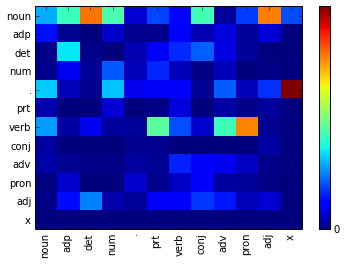

In [16]:
import lxmls.readers.pos_corpus as pcc
BASEPATH='/home/chris/projects/lxmls_2015/lxmls-toolkit/'
corpus = pcc.PostagCorpus()
train_seq = corpus.read_sequence_list_conll(os.path.join(BASEPATH, "data/train-02-21.conll"),max_sent_len=15, max_nr_sent=1000)
test_seq = corpus.read_sequence_list_conll(os.path.join(BASEPATH, "data/test-23.conll"),max_sent_len=15,max_nr_sent=1000)
dev_seq = corpus.read_sequence_list_conll(os.path.join(BASEPATH, "data/dev-22.conll"),max_sent_len=15,max_nr_sent=1000)
hmm = hmmc.HMM(corpus.word_dict, corpus.tag_dict)
hmm.train_supervised(train_seq)
hmm.print_transition_matrix()


In [17]:
viterbi_pred_train = hmm.viterbi_decode_corpus(train_seq)
posterior_pred_train = hmm.posterior_decode_corpus(train_seq)
eval_viterbi_train = hmm.evaluate_corpus(train_seq, viterbi_pred_train)
eval_posterior_train = hmm.evaluate_corpus(train_seq, posterior_pred_train)
print("Train Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(eval_posterior_train,eval_viterbi_train))
# Train Set Accuracy: Posterior Decode 0.985, Viterbi Decode: 0.985
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq,viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq,posterior_pred_test)
print("Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(eval_posterior_test,eval_viterbi_test))


Train Set Accuracy: Posterior Decode 0.985, Viterbi Decode: 0.985
Test Set Accuracy: Posterior Decode 0.350, Viterbi Decode: 0.509


In [18]:
best_smoothing = hmm.pick_best_smoothing(train_seq, dev_seq, [10,1,0.1,0])
hmm.train_supervised(train_seq, smoothing=best_smoothing)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)
print("Best Smoothing %f -- Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(best_smoothing,eval_posterior_test,eval_viterbi_test))


Smoothing 10.000000 --  Train Set Accuracy: Posterior Decode 0.731, Viterbi Decode: 0.691
Smoothing 10.000000 -- Test Set Accuracy: Posterior Decode 0.712, Viterbi Decode: 0.675
Smoothing 1.000000 --  Train Set Accuracy: Posterior Decode 0.887, Viterbi Decode: 0.865
Smoothing 1.000000 -- Test Set Accuracy: Posterior Decode 0.818, Viterbi Decode: 0.792
Smoothing 0.100000 --  Train Set Accuracy: Posterior Decode 0.968, Viterbi Decode: 0.965
Smoothing 0.100000 -- Test Set Accuracy: Posterior Decode 0.851, Viterbi Decode: 0.842
Smoothing 0.000000 --  Train Set Accuracy: Posterior Decode 0.985, Viterbi Decode: 0.985
Smoothing 0.000000 -- Test Set Accuracy: Posterior Decode 0.370, Viterbi Decode: 0.526
Best Smoothing 0.100000 -- Test Set Accuracy: Posterior Decode 0.837, Viterbi Decode: 0.827


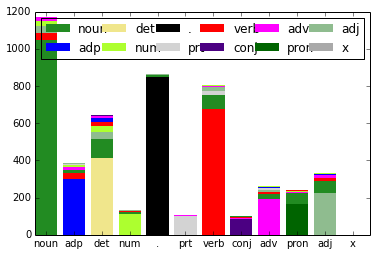

In [19]:
import lxmls.sequences.confusion_matrix as cm
import matplotlib.pyplot as plt
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test, 
                                             len(corpus.tag_dict), hmm.get_num_states())
cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict, xrange(hmm.get_num_states()), 'Confusion matrix')
plt.show()


In [20]:
hmm.train_EM(train_seq, 0.1, 20, evaluate=True)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)


Initial accuracy: 0.364465
Iter: 1 Log Likelihood: -101673.202656
Iter: 1 Accuracy: 0.382804
Iter: 2 Log Likelihood: -78076.577606
Iter: 2 Accuracy: 0.391923
Iter: 3 Log Likelihood: -77863.506763
Iter: 3 Accuracy: 0.401643
Iter: 4 Log Likelihood: -77238.376507
Iter: 4 Accuracy: 0.404049
Iter: 5 Log Likelihood: -76101.256696
Iter: 5 Accuracy: 0.404349
Iter: 6 Log Likelihood: -74964.872746
Iter: 6 Accuracy: 0.405051
Iter: 7 Log Likelihood: -74016.964591
Iter: 7 Accuracy: 0.400641
Iter: 8 Log Likelihood: -73074.176382
Iter: 8 Accuracy: 0.397735
Iter: 9 Log Likelihood: -72020.947250
Iter: 9 Accuracy: 0.390620
Iter: 10 Log Likelihood: -70897.969471
Iter: 10 Accuracy: 0.389017
Iter: 11 Log Likelihood: -69765.293518
Iter: 11 Accuracy: 0.386913
Iter: 12 Log Likelihood: -68735.547704
Iter: 12 Accuracy: 0.386211
Iter: 13 Log Likelihood: -67995.461443
Iter: 13 Accuracy: 0.385710
Iter: 14 Log Likelihood: -67552.199285
Iter: 14 Accuracy: 0.385710
Iter: 15 Log Likelihood: -67306.545053
Iter: 15 Accu

#### Least squares update rule

$\theta_j := \theta_j + \alpha \sum_{i=1}^{m}(y^{(i)}-h_{\theta}(x^{(i)}))x_{j}^{(i)} $ 